In [41]:
import numpy as np
from numpy import sqrt
from utils.TlF import *
import matplotlib.pyplot as plt
from utils.hamiltonianoperators import *

In [19]:
Jmax = 6
QN = np.array([BasisState(J,mJ,I_Tl,m1,I_F,m2)
      for J in range(Jmax+1)
      for mJ in range(-J,J+1)
      for m1 in np.arange(-I_Tl,I_Tl+1)
      for m2 in np.arange(-I_F,I_F+1)])

In [20]:
%%time
def HMatElems(H, QN):
    result = np.empty((len(QN),len(QN)), dtype=complex)
    for i,a in enumerate(QN):
        for j,b in enumerate(QN):
            result[i,j] = (1*a)@H(b)
    return result

Hff_m = HMatElems(Hff, QN)
HSx_m = HMatElems(HSx, QN)
HSy_m = HMatElems(HSy, QN)
HSz_m = HMatElems(HSz, QN)
HZx_m = HMatElems(HZx, QN)
HZy_m = HMatElems(HZy, QN)
HZz_m = HMatElems(HZz, QN)

Wall time: 32.5 s


In [37]:
import itertools

def index_range(J):
    return 4*(J)**2, 4*(J+1)**2

def generate_Q0a(H0, P0, J, Jmax):
    E = np.linalg.eigh(H0)[0]
    idx_min, idx_max = index_range(J)
    Q0 = np.eye(4*(Jmax+1)**2) - P0
    for j in range(Jmax+1):
        if J != j:
            idmin, idmax = index_range(j)
            Q0[idmin:idmax,idmin:idmax] /= np.mean(E[idx_min:idx_max]) - np.mean(E[idmin:idmax])
    return Q0

def compress_variables(d):
    for order in d.keys():
        ax = list(d[order].keys())
        for axes in ax:
            for c in itertools.permutations(axes):
                c = ''.join(c)
                if c != axes:
                    if not isinstance(d[order].get(c), type(None)):
                        d[order][axes] += d[order][c]
                        ax.remove(c)
                        del d[order][c]
    return d

def generate_effective_hamiltonian_hand(H0, Hmats, J=2, Jmax = 6):
    idx_min, idx_max = index_range(J)
    P0 = np.eye(4*(Jmax+1)**2)
    mask = np.zeros(P0.shape, dtype = bool)
    mask[idx_min:idx_max, idx_min:idx_max] = True
    P0[~mask] = 0
    E = np.linalg.eigh(H0)[0]
    Q0 = generate_Q0a(H0, P0, J, Jmax)
    Q02 = Q0.copy()
    for j in range(Jmax+1):
        if J != j:
            idmin, idmax = index_range(j)
            Q02[idmin:idmax,idmin:idmax] /= np.mean(E[idx_min:idx_max]) - np.mean(E[idmin:idmax])
    Q03 = Q02.copy()
    for j in range(Jmax+1):
        if J != j:
            idmin, idmax = index_range(j)
            Q03[idmin:idmax,idmin:idmax] /= np.mean(E[idx_min:idx_max]) - np.mean(E[idmin:idmax])
    coords = ['x', 'y', 'z']
    
    Heff = dict()
    
    Heff[0] = dict()
    for ax1, H1 in zip(coords, Hmats):
        val = P0@H1@P0
        if np.abs(val).sum() == 0:
            continue
        Heff[ax1] = val[idx_min:idx_max,idx_min:idx_max]
        
    Heff[1] = dict()
    for (ax1, ax2), (H1, H2) in zip(itertools.product(*[coords]*2), itertools.product(*[Hmats]*2)):
        val = P0@H1@Q0@H2@P0
        if np.abs(val).sum() == 0:
            continue
        if ax1+ax2 in Heff[1]:
            Heff[1][ax1+ax2] += val[idx_min:idx_max,idx_min:idx_max]
        else:
            Heff[1][ax1+ax2] = val[idx_min:idx_max,idx_min:idx_max]
    
    Heff[2] = dict()
    for (ax1, ax2, ax3), (H1, H2, H3) in zip(itertools.product(*[coords]*3), itertools.product(*[Hmats]*3)):
        val = P0@H1@Q0@H2@Q0@H3@P0 - P0@H1@Q02@H2@P0@H3@P0
        if np.abs(val).sum() == 0:
            continue
        ax = ax1+ax2+ax3
        if ax in Heff[2]:
            Heff[2][ax] += val[idx_min:idx_max,idx_min:idx_max]
        else:
            Heff[2][ax] = val[idx_min:idx_max,idx_min:idx_max]
    
    Heff[3] = dict()
    for (ax1, ax2, ax3, ax4), (H1, H2, H3, H4) in zip(itertools.product(*[coords]*4), itertools.product(*[Hmats]*4)):
        val = P0@H1@Q0@H2@Q0@H3@Q0@H4@P0 - P0@H1@Q0@H2@Q02@H3@P0@H4@P0 - P0@H1@Q02@H2@Q0@H3@P0@H4@P0 + P0@H1@Q03@H2@P0@H3@P0@H4@P0 - P0@H1@Q02@H2@P0@H3@Q0@H4@P0
        if np.abs(val).sum() == 0:
            continue
        ax = ax1+ax2+ax3+ax4
        if ax in Heff[3]:
            Heff[3][ax] += val[idx_min:idx_max,idx_min:idx_max]
        else:
            Heff[3][ax] = val[idx_min:idx_max,idx_min:idx_max]
    return Heff

def generate_effective_hamiltonian(H0, Hmats, J = 2, order = 2, Jmax = 6):
    idx_min, idx_max = index_range(J)
    P0 = np.eye(4*(Jmax+1)**2)
    mask = np.zeros(P0.shape, dtype = bool)
    mask[idx_min:idx_max, idx_min:idx_max] = True
    P0[~mask] = 0
    
    Q0 = generate_Q0a(H0, P0, J, Jmax)
    
    coords = ['x', 'y', 'z']
    
    U = dict([(0,dict([('', P0)]))])
    for o in range(1, order+1):
        U[o] = dict()
        for axis, Hpert in zip(coords, Hmats):
            for axes, mat in U[o-1].items():
                product = Q0@(Hpert@mat)
                if np.abs(product).sum() == 0:
                    continue
                if axis+axes in U[o]:
                    U[o][axis+axes] += product
                else:
                    U[o][axis+axes] = product
            
        for axis, Hpert in zip(coords, Hmats):
            for p in range(1,o):
                for axes_p, mat_p in U[p].items():
                    for axes, mat in U[o-p-1].items():
                        product = Q0@(mat_p@Hpert@mat)
                        if np.abs(product).sum() == 0:
                            continue
                        if axis+axes_p+axes in U[o]:
                            U[o][axis+axes_p+axes] -= product
                        else:
                            U[o][axis+axes_p+axes] = -product
        U = compress_variables(U)
    
    Heff = dict()
    for o in range(order+1):
        Heff[o] = dict()
        for axis, Hpert in zip(coords, Hmats):
            for axes, mat in U[o].items():
                product = P0@Hpert@mat
                if np.abs(product).sum() == 0:
                    continue
                if axis+axes in Heff[o]:
                    Heff[o][axis+axes] += (P0@Hpert@mat)[idx_min:idx_max, idx_min:idx_max]
                else:
                    Heff[o][axis+axes] = (P0@Hpert@mat)[idx_min:idx_max,idx_min:idx_max]
    Heff = compress_variables(Heff)
    
                
    return U, Heff

In [22]:
from sympy import *

def generate_U_testing(Hmats, J = 2, order = 3, Jmax = 6):
    idx_min, idx_max = index_range(J)
    P0 = MatrixSymbol("P0", 196,196)
    Q0 = MatrixSymbol('Q0', 196,196)
    Hmats = [MatrixSymbol(val, 196,196) for val in Hmats]
    coords = ['x', 'y', 'z']
    
    U = dict([(0,dict([('', P0)]))])
    for o in range(1, order+1):
        U[o] = dict()
        for axis, Hpert in zip(coords, Hmats):
            for axes, mat in U[o-1].items():
                product = Q0*Hpert*mat
                if axis+axes in U[o]:
                    U[o][axis+axes] += product
                else:
                    U[o][axis+axes] = product
            
        for axis, Hpert in zip(coords, Hmats):
            for p in range(1,o):
                for axes_p, mat_p in U[p].items():
                    for axes, mat in U[o-p-1].items():
                        product = Q0*mat_p*Hpert*mat
                        if axis+axes_p+axes in U[o]:
                            U[o][axis+axes_p+axes] -= product
                        else:
                            U[o][axis+axes_p+axes] = -product
    Heff = dict()
    for o in range(order+1):
        Heff[o] = dict()
        for axis, Hpert in zip(coords, Hmats):
            for axes, mat in U[o].items():
                product = P0*Hpert*mat
                if axis+axes in Heff[o]:
                    Heff[o][axis+axes] += (product)
                else:
                    Heff[o][axis+axes] = (product)
                
    return U, Heff

In [23]:
U, HeffSymbolic = generate_U_testing(['HSx', 'HSy', 'HSz'], order = 3)

In [24]:
U[1]['x']

Q0*HSx*P0

In [25]:
U[2]['xx']

-Q0**2*HSx*P0*HSx*P0 + Q0*HSx*Q0*HSx*P0

In [26]:
U[3]['yxx']

-Q0**2*HSx*P0*HSy*Q0*HSx*P0 - Q0*(-Q0**2*HSx*P0*HSx*P0 + Q0*HSx*Q0*HSx*P0)*HSy*P0 + Q0*HSy*(-Q0**2*HSx*P0*HSx*P0 + Q0*HSx*Q0*HSx*P0)

In [27]:
HeffSymbolic[3]['xyxx']

P0*HSx*(-Q0**2*HSx*P0*HSy*Q0*HSx*P0 - Q0*(-Q0**2*HSx*P0*HSx*P0 + Q0*HSx*Q0*HSx*P0)*HSy*P0 + Q0*HSy*(-Q0**2*HSx*P0*HSx*P0 + Q0*HSx*Q0*HSx*P0))

In [28]:
Hrot_m = HMatElems(Hrot, QN)

In [29]:
H0 = Hrot_m
Jmax = 6
J = 2
idx_min, idx_max = index_range(J)
P0 = np.eye(4*(Jmax+1)**2)
mask = np.zeros(P0.shape, dtype = bool)
mask[idx_min:idx_max, idx_min:idx_max] = True
P0[~mask] = 0

Q0 = generate_Q0a(H0, P0, J, Jmax)
del H0

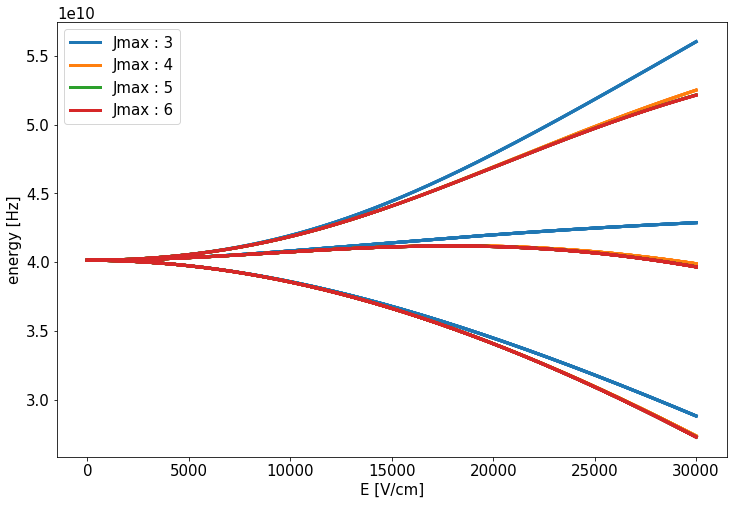

In [30]:
fig, ax = plt.subplots(figsize = (12,8))
E = np.linspace(0,30000,501)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
for jmax in range(3,7):
    idmax = 4*(jmax+1)**2
    Elevels = np.linalg.eigh(Hrot_m[:idmax,:idmax]+np.einsum('i,jk -> ijk', E, HSz_m[:idmax,:idmax]))[0]
    ax.plot(E, Elevels[:,16:35], colors[jmax-3], lw = 3)
    ax.plot(E, Elevels[:,35], colors[jmax-3], label = f'Jmax : {jmax}', lw = 3)
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
ax.set_ylabel('energy [Hz]')
set_fontsize(ax, 15)

So the bending of the energy levels comes about due to the higher order J states coupling back to J=2 at high fields (which makes the coupling stronger).

## Toy Model $H_{rot}+H_{stark}$

In [31]:
Hrot_m = HMatElems(Hrot, QN)

In [39]:
%%time
U, Hpertubation = generate_effective_hamiltonian(Hrot_m, [HSx_m, HSy_m, HSz_m], J=2, order = 3, Jmax = 6)
del U

Wall time: 200 ms


In [40]:
Hpertubation[1].keys()

dict_keys(['xx', 'xy', 'xz', 'yy', 'yz', 'zz'])

In [297]:
import pickle
with open('Heff_11th_toy.dat', 'rb') as rfp:
    Hpertubation = pickle.load(rfp)

In [298]:
Hpertubation_manual = generate_effective_hamiltonian_hand(Hrot_m, [HSx_m, HSy_m, HSz_m], J=2, Jmax = 6)

In [299]:
Hrot_m = HMatElems(Hrot,QN)

def Hfull(Ex, Ey, Ez):
    return Hrot_m + Ex*HSx_m + Ey*HSy_m + Ez*HSz_m

In [300]:
def Heff(H0, Hpertubation, Ex, Ey, Ez, J = 2):
    E = dict([('', 1), ('x', Ex), ('y', Ey), ('z', Ez)])
    idx_min, idx_max = index_range(J)
    
    Heff = np.zeros([4*(2*J+1), 4*(2*J+1)], dtype = 'complex')
    for axes, Hpert in Hpertubation.items():
        Eval = np.product([E[ax] for ax in axes])
        Heff += Eval*Hpert
    
    return H0[idx_min:idx_max, idx_min:idx_max] + Heff

In [301]:
Hpert = dict()
for H in Hpertubation.values():
    Hpert.update(H)

In [302]:
Emax = 15000
# Ex = np.linspace(0,Emax,101)
Ex = np.zeros(101)
# Ey = np.linspace(0,Emax,101)
Ey = np.zeros(101)
Ez = np.linspace(0,Emax,101)
E = np.sqrt(Ex**2+Ey**2+Ez**2)

In [303]:
Hfull_numerical = np.array([Hfull(Exi, Eyi ,Ezi) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
energies_full, eigvecs = np.linalg.eigh(Hfull_numerical)

Heff_numerical = np.array([Heff(Hrot_m, Hpert, Exi,Eyi,Ezi) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
energies_eff, eigvecs = np.linalg.eigh(Heff_numerical)

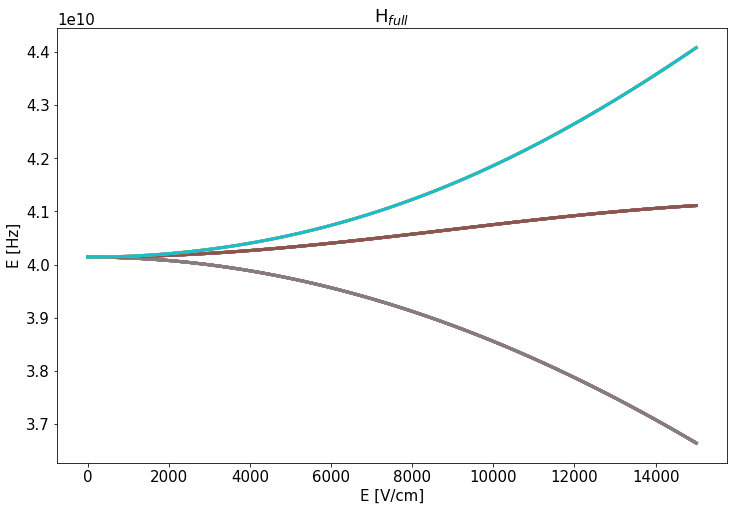

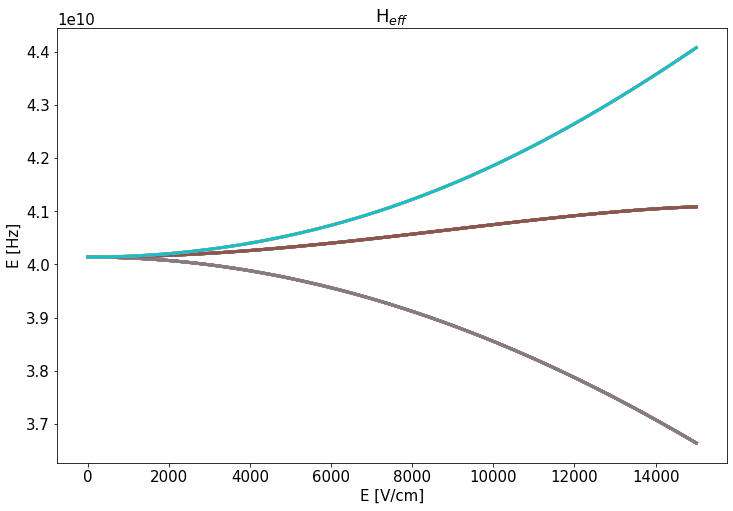

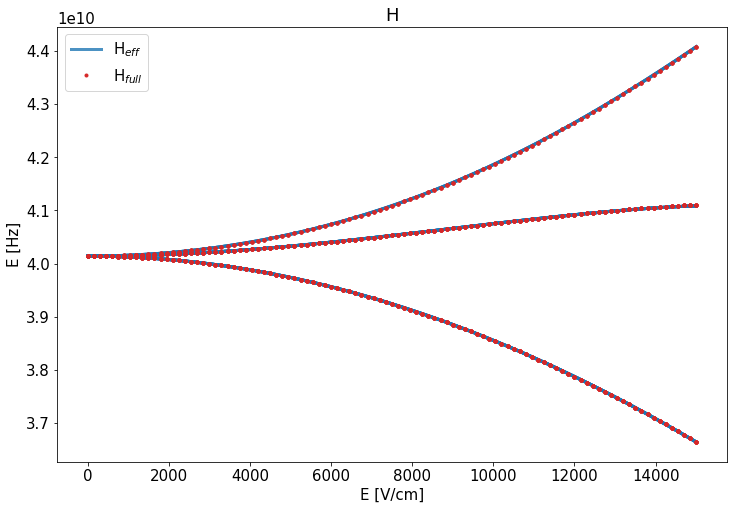

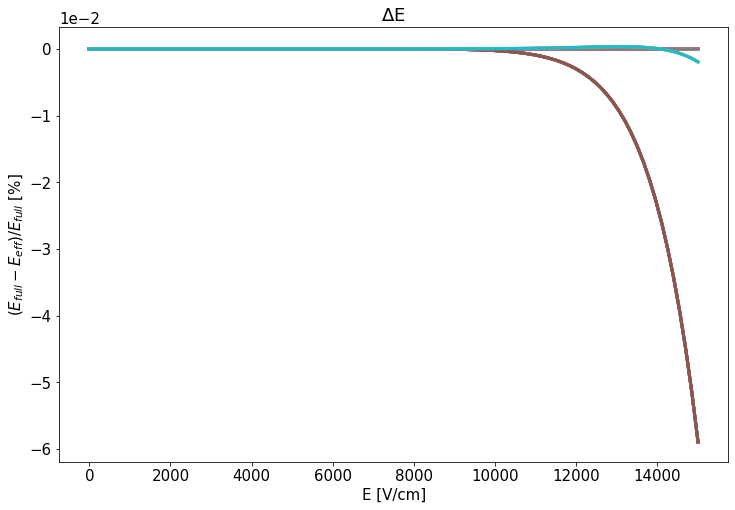

In [304]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, energies_full[:,16:36], '-', lw = 3);
ax.set_title(r'H$_{full}$')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, energies_eff, '-', lw = 3);
ax.set_xlabel(r'E [V/cm]')
ax.set_title(r'H$_{eff}$')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
l1 = ax.plot(E, energies_eff, 'C0-', lw = 3, label = r'H$_{eff}$', alpha = 0.8);
l2 = ax.plot(E, energies_full[:,16:36], 'C3.', label = r'H$_{full}$');
ax.legend([l1[0],l2[0]], [l1[0].get_label(),l2[0].get_label()], fontsize = 15)
ax.set_xlabel(r'E [V/cm]')
ax.set_title(r'H')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, 100*(energies_eff-energies_full[:,16:36])/(energies_full[:,16:36]), lw = 3);
ax.set_title(r'$\Delta$E')
ax.set_xlabel(r'E [V/cm]')
ax.set_ylabel(r'$\left(E_{full}-E_{eff}\right)/E_{full}$ [%]')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
set_fontsize(ax, 15)

order 1 took 3.30e-02 s to calculate
order 3 took 2.61e-01 s to calculate
order 5 took 1.23e+00 s to calculate
order 7 took 5.55e+00 s to calculate
order 9 took 3.39e+01 s to calculate


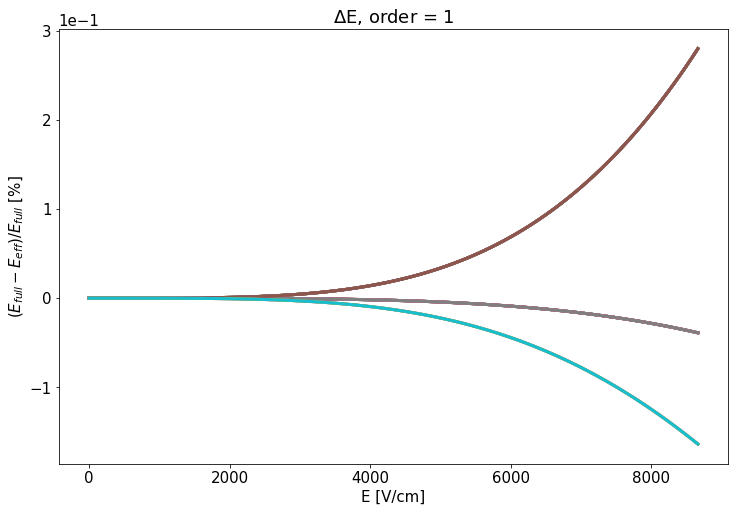

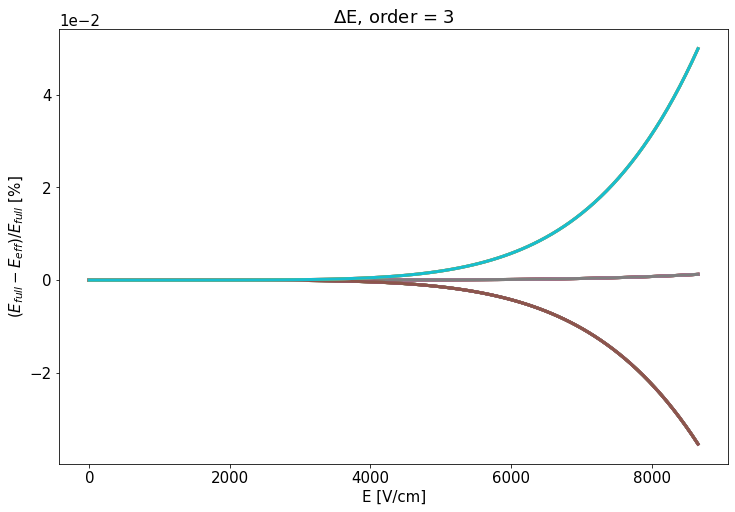

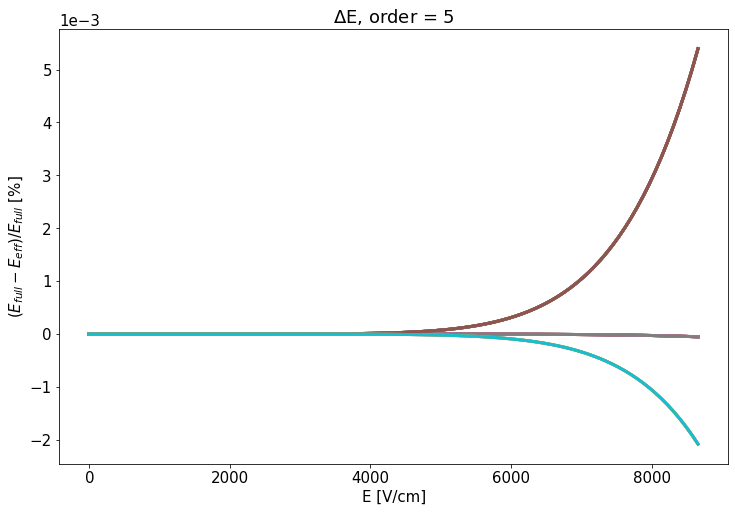

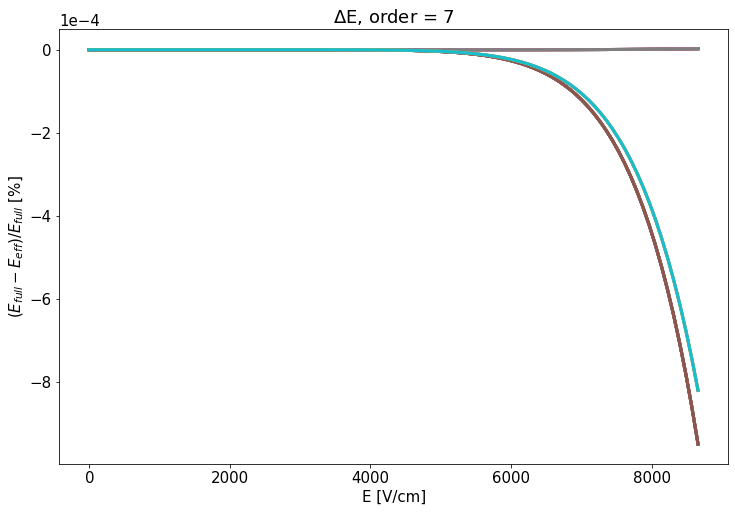

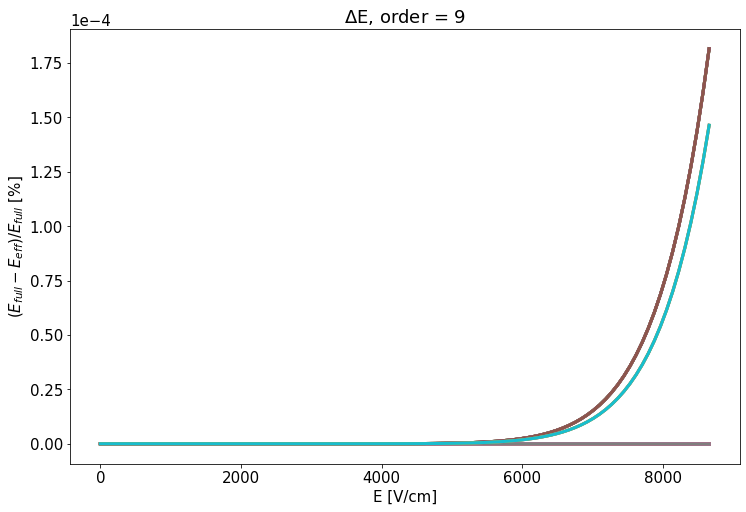

In [305]:
import time
Emax = np.sqrt(5000**2+5000**2+5000**2)
# Ex = np.linspace(0,Emax,101)
Ex = np.zeros(101)
# Ey = np.linspace(0,Emax,101)
Ey = np.zeros(101)
Ez = np.linspace(0,Emax,101)
E = np.sqrt(Ex**2+Ey**2+Ez**2)


for order in range(1,10,2):
    tstart = time.time()
    U, Hpertubation = generate_effective_hamiltonian(Hrot_m, [HSx_m, HSy_m, HSz_m], J=2, order = order, Jmax = 6)
    print(f'order {order} took {time.time() - tstart:.2e} s to calculate')
    Hpert = dict()
    for H in Hpertubation.values():
        Hpert.update(H)

    Hfull_numerical = np.array([Hfull(Exi, Eyi ,Ezi) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
    energies_full, eigvecs = np.linalg.eigh(Hfull_numerical)

    Heff_numerical = np.array([Heff(Hrot_m, Hpert, Exi,Eyi,Ezi) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
    energies_eff, eigvecs = np.linalg.eigh(Heff_numerical)
    
    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(E, 100*(energies_eff-energies_full[:,16:36])/(energies_full[:,16:36]), lw = 3);
    ax.set_title(r'$\Delta$E'+f', order = {order}')
    ax.set_xlabel(r'E [V/cm]')
    ax.set_ylabel(r'$\left(E_{full}-E_{eff}\right)/E_{full}$ [%]')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    set_fontsize(ax, 15)
del U, Hpertubation, Hpert, Hfull_numerical, Heff_numerical, energies_full, energies_eff, eigvecs

# Full Hamiltonian @ 20 Gauss $B_z$

In [114]:
%%time
U, Hpertubation = generate_effective_hamiltonian(Hff_m+20*HZz_m, [HSx_m, HSy_m, HSz_m], J=2, order = 9, Jmax = 6)

Wall time: 34.6 s


In [115]:
import pickle
with open('Heff_Bz_20G_9th_full.dat', 'wb') as wfp:
    pickle.dump(Hpertubation, wfp)

In [1]:
import pickle
with open('Heff_Bz_20G_7th_full.dat', 'rb') as rfp:
    Hpertubation = pickle.load(rfp)

In [2]:
def Hfull(Ex, Ey, Ez):
    return Hff_m + 18.4*HZz_m + Ex*HSx_m + Ey*HSy_m + Ez*HSz_m

def Heff(H0, Hpertubation, Ex, Ey, Ez, J = 2):
    E = dict([('', 1), ('x', Ex), ('y', Ey), ('z', Ez)])
    idx_min, idx_max = index_range(J)
    
    Heff = np.zeros([4*(2*J+1), 4*(2*J+1)], dtype = 'complex')
    for axes, Hpert in Hpertubation.items():
        Eval = np.product([E[ax] for ax in axes])
        Heff += Eval*Hpert
    
    return H0[idx_min:idx_max, idx_min:idx_max] + Heff

In [3]:
Hpert = dict()
for H in Hpertubation.values():
    Hpert.update(H)

In [4]:
Emax = 15000
steps = 101
# Ex = np.linspace(0,Emax,steps)
Ex = np.zeros(steps)
# Ey = np.linspace(0,Emax,steps)
Ey = np.zeros(steps)
Ez = np.linspace(0,Emax,steps)
E = np.sqrt(Ex**2+Ey**2+Ez**2)

NameError: name 'np' is not defined

In [514]:
Hfull_numerical = np.array([Hfull(Exi, Eyi ,Ezi) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
energies_full, eigvecs = np.linalg.eigh(Hfull_numerical)

Heff_numerical = np.array([Heff(Hff_m+20*HZz_m, Hpert, Exi,Eyi,Ezi, J=2) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
energies_eff, eigvecs = np.linalg.eigh(Heff_numerical)

ValueError: operands could not be broadcast together with shapes (20,20) (12,12) (20,20) 

In [ ]:
fig, ax = plt.subplots(figsize = (8,16))
ax.plot(E, energies_full[:,16:36], '-', lw = 3);
ax.set_title(r'H$_{full}$')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (8,16))
ax.plot(E, energies_eff, '-', lw = 3);
ax.set_xlabel(r'E [V/cm]')
ax.set_title(r'H$_{eff}$')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
l1 = ax.plot(E, energies_eff, 'C0-', lw = 3, label = r'H$_{eff}$', alpha = 0.8);
l2 = ax.plot(E, energies_full[:,16:36], 'C3.', label = r'H$_{full}$');
ax.legend([l1[0],l2[0]], [l1[0].get_label(),l2[0].get_label()], fontsize = 15)
ax.set_xlabel(r'E [V/cm]')
ax.set_title(r'H')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, 100*(energies_eff-energies_full[:,16:36])/(energies_full[:,16:36]), lw = 3);
ax.set_title(r'$\Delta$E')
ax.set_xlabel(r'E [V/cm]')
ax.set_ylabel(r'$\left(E_{full}-E_{eff}\right)/E_{full}$ [%]')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
set_fontsize(ax, 15)

## Full Hamiltonian @ 18.4 Gaus $B_z$ for J=1 (Ramsey paper)

In [491]:
%%time
U, Hpertubation = generate_effective_hamiltonian(Hff_m+18.4*HZz_m, [HSx_m, HSy_m, HSz_m], J=1, order = 7, Jmax = 6)

Wall time: 5.81 s


In [492]:
def Hfull(Ex, Ey, Ez):
    return Hff_m + 18.4*HZz_m + Ex*HSx_m + Ey*HSy_m + Ez*HSz_m

def Heff(H0, Hpertubation, Ex, Ey, Ez, J = 2):
    E = dict([('', 1), ('x', Ex), ('y', Ey), ('z', Ez)])
    idx_min, idx_max = index_range(J)
    
    Heff = np.zeros([4*(2*J+1), 4*(2*J+1)], dtype = 'complex')
    for axes, Hpert in Hpertubation.items():
        Eval = np.product([E[ax] for ax in axes])
        Heff += Eval*Hpert
    
    return H0[idx_min:idx_max, idx_min:idx_max] + Heff

In [493]:
Hpert = dict()
for H in Hpertubation.values():
    Hpert.update(H)

In [494]:
Emax = 70
steps = 101
# Ex = np.linspace(0,Emax,steps)
Ex = np.zeros(steps)
# Ey = np.linspace(0,Emax,steps)
Ey = np.zeros(steps)
Ez = np.linspace(0,Emax,steps)
E = np.sqrt(Ex**2+Ey**2+Ez**2)

In [499]:
Hfull_numerical = np.array([Hfull(Exi, Eyi ,Ezi) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
energies_full, eigvecs = np.linalg.eigh(Hfull_numerical)

Heff_numerical = np.array([Heff(Hff_m+18.4*HZz_m, Hpert, Exi,Eyi,Ezi, J=1) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
energies_eff, eigvecs = np.linalg.eigh(Heff_numerical)

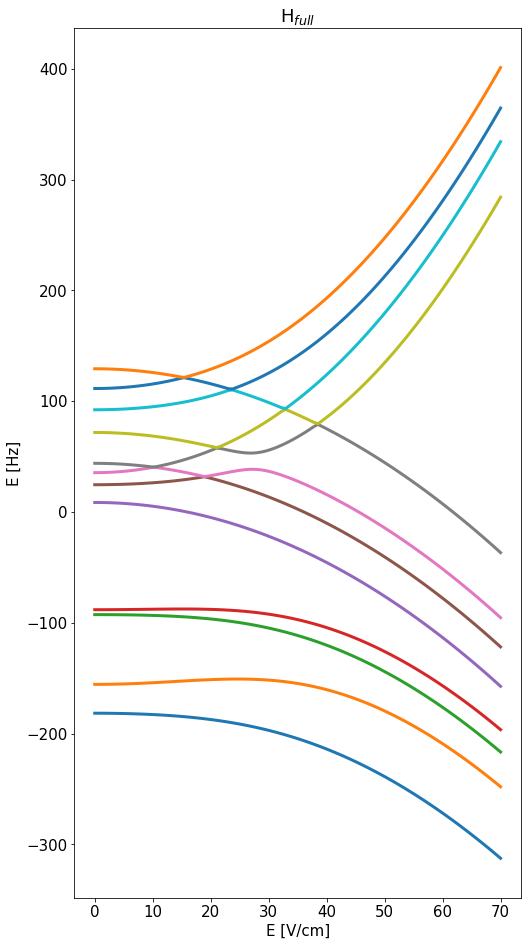

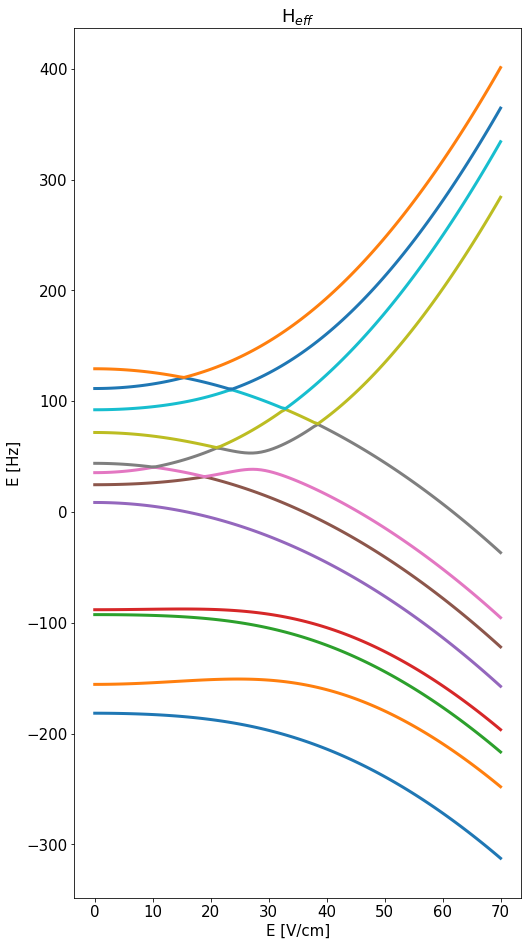

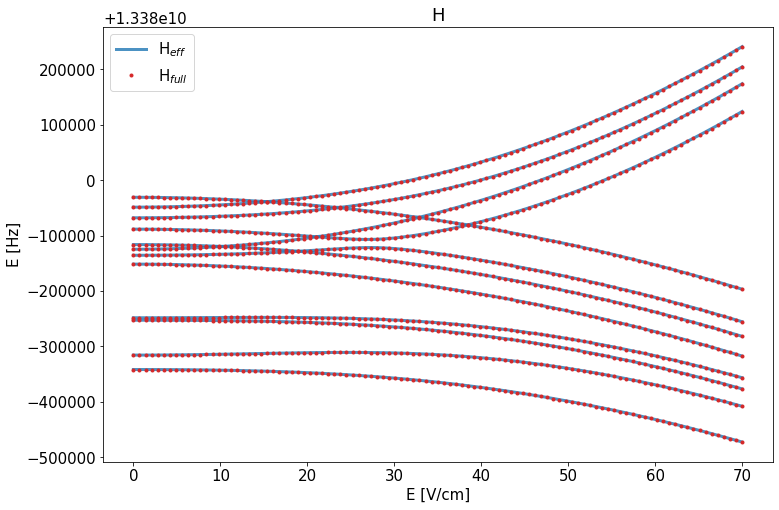

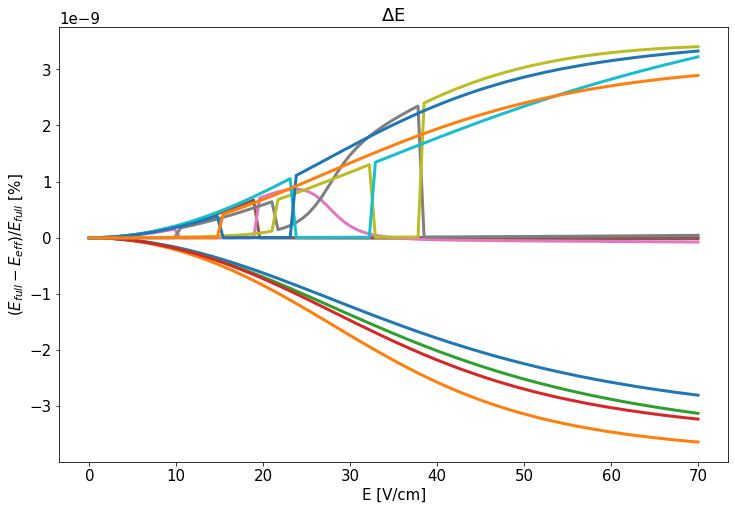

In [500]:
fig, ax = plt.subplots(figsize = (8,16))
ax.plot(E, (energies_full[:,4:16]-np.linalg.eigh(Hrot_m)[0][4:16])/1e3, '-', lw = 3);
ax.set_title(r'H$_{full}$')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (8,16))
ax.plot(E, (energies_eff[:]-np.linalg.eigh(Hrot_m)[0][4:16])/1e3, '-', lw = 3);
ax.set_xlabel(r'E [V/cm]')
ax.set_title(r'H$_{eff}$')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
l1 = ax.plot(E, energies_eff, 'C0-', lw = 3, label = r'H$_{eff}$', alpha = 0.8);
l2 = ax.plot(E, energies_full[:,4:16], 'C3.', label = r'H$_{full}$');
ax.legend([l1[0],l2[0]], [l1[0].get_label(),l2[0].get_label()], fontsize = 15)
ax.set_xlabel(r'E [V/cm]')
ax.set_title(r'H')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, 100*(energies_eff-energies_full[:,4:16])/(energies_full[:,4:16]), lw = 3);
ax.set_title(r'$\Delta$E')
ax.set_xlabel(r'E [V/cm]')
ax.set_ylabel(r'$\left(E_{full}-E_{eff}\right)/E_{full}$ [%]')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
set_fontsize(ax, 15)

## Full Effective Hamiltonian @0.5G, 400 V/cm for Jakob to compare with his method

In [393]:
%%time
U, Hpertubation = generate_effective_hamiltonian(Hff_m+0.5*HZz_m, [HSx_m, HSy_m, HSz_m], J=2, order = 9, Jmax = 6)

Wall time: 34 s


In [394]:
Hpert = dict()
for H in Hpertubation.values():
    Hpert.update(H)

In [395]:
%%time
Heff_numerical = Heff(Hff_m+0.5*HZz_m, Hpert, 0,0,400)

Wall time: 10 ms


In [396]:
Emin = 200
Emax = 500
steps = 101
# Ex = np.linspace(Emin,Emax,steps)
Ex = np.zeros(steps)
# Ey = np.linspace(Emin,Emax,steps)
Ey = np.zeros(steps)
Ez = np.linspace(Emin,Emax,steps)
E = np.sqrt(Ex**2+Ey**2+Ez**2)

def Hfull(Ex, Ey, Ez):
    return Hff_m + 0.5*HZz_m + Ex*HSx_m + Ey*HSy_m + Ez*HSz_m

Hfull_numerical = np.array([Hfull(Exi, Eyi ,Ezi) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
energies_full, eigvecs = np.linalg.eigh(Hfull_numerical)

Heff_numerical = np.array([Heff(Hff_m+0.5*HZz_m, Hpert, Exi,Eyi,Ezi) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
energies_eff, eigvecs = np.linalg.eigh(Heff_numerical)

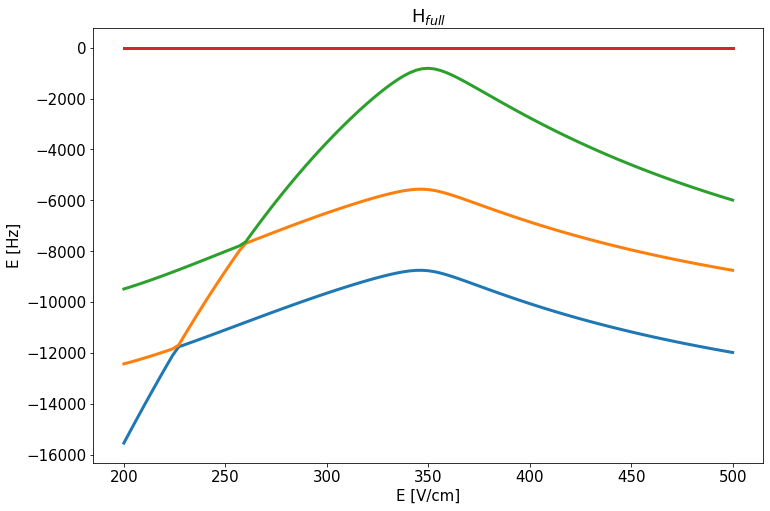

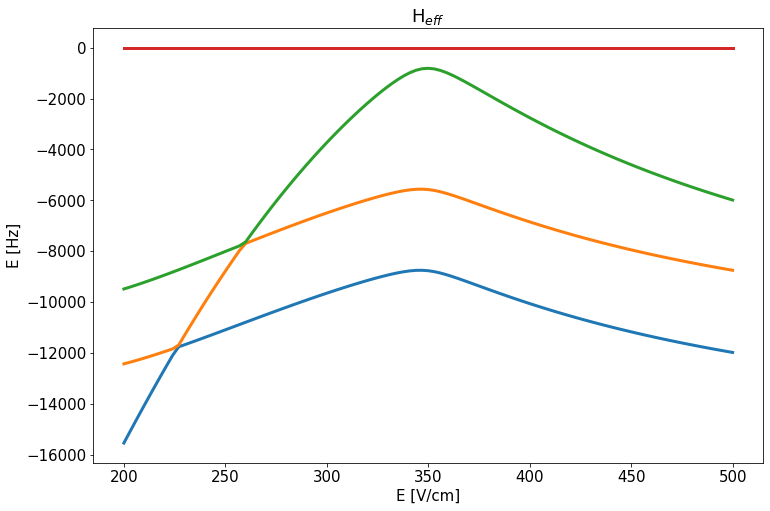

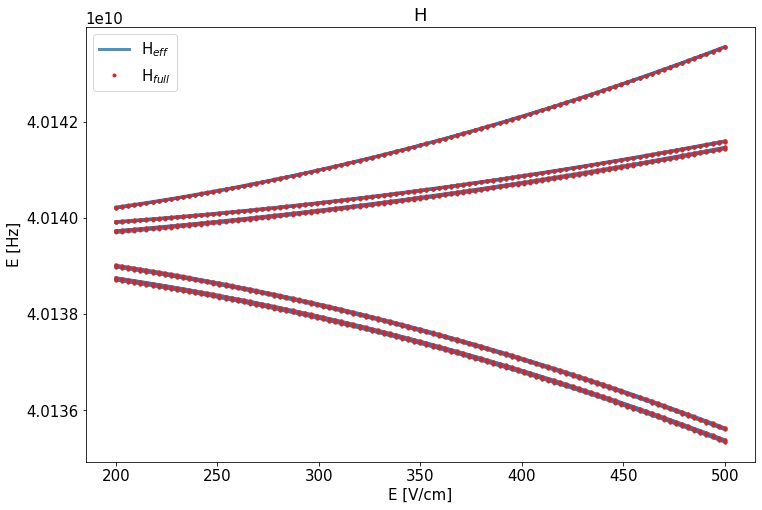

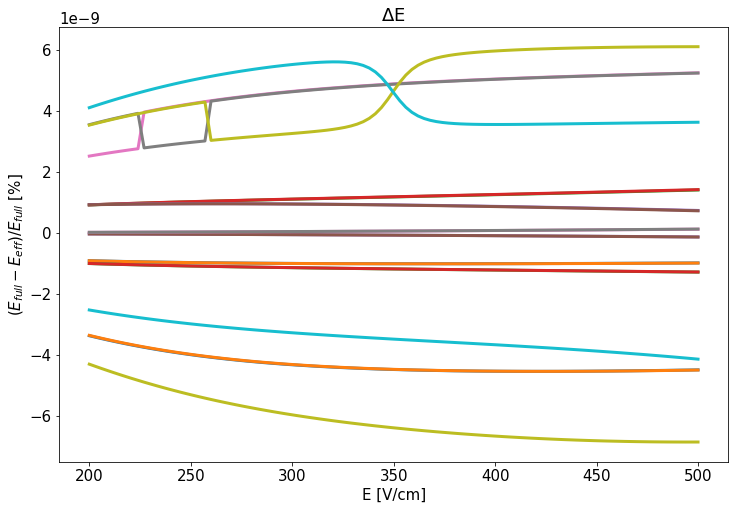

In [399]:
fig, ax = plt.subplots(figsize = (12,8))
for idx in range(32,36):
    ax.plot(E, energies_full[:,idx]-energies_full[:,35], '-', lw = 3);
ax.set_title(r'H$_{full}$')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
for idx in range(16,20):
    ax.plot(E, energies_eff[:,idx]-energies_eff[:,19], '-', lw = 3);
ax.set_xlabel(r'E [V/cm]')
ax.set_title(r'H$_{eff}$')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
l1 = ax.plot(E, energies_eff, 'C0-', lw = 3, label = r'H$_{eff}$', alpha = 0.8);
l2 = ax.plot(E, energies_full[:,16:36], 'C3.', label = r'H$_{full}$');
ax.legend([l1[0],l2[0]], [l1[0].get_label(),l2[0].get_label()], fontsize = 15)
ax.set_xlabel(r'E [V/cm]')
ax.set_title(r'H')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, 100*(energies_eff-energies_full[:,16:36])/(energies_full[:,16:36]), lw = 3);
ax.set_title(r'$\Delta$E')
ax.set_xlabel(r'E [V/cm]')
ax.set_ylabel(r'$\left(E_{full}-E_{eff}\right)/E_{full}$ [%]')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
set_fontsize(ax, 15)

# Generalizing the Effective Hamiltonian creation
Slower if you give it variables with multiple characters and then split using ',', probably because it has to search for each ',' in the ever larger lists.

In [166]:
import itertools

def index_range(J):
    return 4*(J)**2, 4*(J+1)**2

def generate_Q0a(H0, P0, J, Jmax):
    E = np.linalg.eigh(H0)[0]
    idx_min, idx_max = index_range(J)
    Q0 = np.eye(4*(Jmax+1)**2) - P0
    for j in range(Jmax+1):
        if J != j:
            idmin, idmax = index_range(j)
            Q0[idmin:idmax,idmin:idmax] /= np.mean(E[idx_min:idx_max]) - np.mean(E[idmin:idmax])
    return Q0

def compress_variables(d):
    ax = list(d.keys())
    for axes in ax:
        for c in itertools.permutations(axes.split(',')):
            c = ','.join(c)
            if c != axes:
                if not isinstance(d.get(c), type(None)):
                    d[axes] += d[c]
                    ax.remove(c)
                    del d[c]
    return d

def generate_effective_hamiltonian(H0, variables, Hmats, J = 2, order = 2, Jmax = 6):
    idx_min, idx_max = index_range(J)
    P0 = np.eye(4*(Jmax+1)**2)
    mask = np.zeros(P0.shape, dtype = bool)
    mask[idx_min:idx_max, idx_min:idx_max] = True
    P0[~mask] = 0
    
    Q0 = generate_Q0a(H0, P0, J, Jmax)
        
    U = dict([(0,dict([('', P0)]))])
    for o in range(1, order+1):
        U[o] = dict()
        for axis, Hpert in zip(variables, Hmats):
            for axes, mat in U[o-1].items():
                product = Q0@(Hpert@mat)
                if np.abs(product).sum() == 0:
                    continue
                if axis+axes in U[o]:
                    U[o][axis+','+axes] += product
                else:
                    U[o][axis+','+axes] = product
            
        for axis, Hpert in zip(variables, Hmats):
            for p in range(1,o):
                for axes_p, mat_p in U[p].items():
                    for axes, mat in U[o-p-1].items():
                        product = Q0@(mat_p@Hpert@mat)
                        if np.abs(product).sum() == 0:
                            continue
                        if axis+axes_p+axes in U[o]:
                            U[o][axis+','+axes_p+','+axes] -= product
                        else:
                            U[o][axis+','+axes_p+','+axes] = -product
        U[o] = compress_variables(U[o])
    
    Heff = dict()
    for o in range(order+1):
        Heff[o] = dict()
        for axis, Hpert in zip(variables, Hmats):
            for axes, mat in U[o].items():
                product = P0@Hpert@mat
                if np.abs(product).sum() == 0:
                    continue
                if axis+axes in Heff[o]:
                    Heff[o][axis+','+axes] += (P0@Hpert@mat)[idx_min:idx_max, idx_min:idx_max]
                else:
                    Heff[o][axis+','+axes] = (P0@Hpert@mat)[idx_min:idx_max,idx_min:idx_max]
        Heff[o] = compress_variables(Heff[o])
    
    
                
    return U, Heff

In [172]:
%%time
U, Hpertubation = generate_effective_hamiltonian(Hff_m+20*HZz_m, ['Ex', 'Ey', 'Ez'], [HSx_m, HSy_m, HSz_m], J=2, order = 5, Jmax = 6)

Wall time: 10.8 s


# Speeding up the original code

In [36]:
import itertools

def index_range(J):
    return 4*(J)**2, 4*(J+1)**2

def generate_Q0a(H0, P0, J, Jmax):
    E = np.linalg.eigh(H0)[0]
    idx_min, idx_max = index_range(J)
    Q0 = np.eye(4*(Jmax+1)**2) - P0
    for j in range(Jmax+1):
        if J != j:
            idmin, idmax = index_range(j)
            Q0[idmin:idmax,idmin:idmax] /= np.mean(E[idx_min:idx_max]) - np.mean(E[idmin:idmax])
    return Q0

def compress_variables(d):
    """
    Compressing variable permutations into one matrix, e.g. xy, yx -> xy.
    """
    ax = list(d.keys())
    for axes in ax:
        for c in itertools.permutations(axes):
            c = ''.join(c)
            if c != axes:
                if not isinstance(d.get(c), type(None)):
                    d[axes] += d[c]
                    ax.remove(c)
                    del d[c]
    return d

def generate_effective_hamiltonian(H0, variables, Hpertubations, J = 2, order = 2, Jmax = 6):
    """"
    Function to generate the effective Hamiltonian in the specified J state
    
    H0            : unperturbed Hamiltonian  
    variables     : list of variables corresponding to the list of Hpertubations
    Hpertubations : list of perturbing Hamiltonians
    J             : J state to create effective Hamiltonian in
    order         : to which order to calculate the pertubation
    Jmax          : maximum J state in the unperturbed Hamiltonian
    
    See Brown-Carrington Chapter 7 a description of the derivation.
    """
    # determining the indices of the block corresponding to J
    idx_min, idx_max = index_range(J)
    
    # operator selecting only the J block matrix elements
    P0 = np.eye(4*(Jmax+1)**2)
    mask = np.zeros(P0.shape, dtype = bool)
    mask[idx_min:idx_max, idx_min:idx_max] = True
    P0[~mask] = 0
    
    # operator projecting off J block elements onto the J block
    Q0 = generate_Q0a(H0, P0, J, Jmax)
    
    # calculating the contributing U terms 
    U = dict([(0,dict([('', P0)]))])
    for o in range(1, order+1):
        U[o] = dict()
        for axis, Hpert in zip(variables, Hpertubations):
            for axes, mat in U[o-1].items():
                product = Q0@(Hpert@mat)
                if np.abs(product).sum() == 0:
                    continue
                if axis+axes in U[o]:
                    U[o][axis+axes] += product
                else:
                    U[o][axis+axes] = product
            
        for axis, Hpert in zip(variables, Hpertubations):
            for p in range(1,o):
                for axes_p, mat_p in U[p].items():
                    for axes, mat in U[o-p-1].items():
                        product = Q0@(mat_p@Hpert@mat)
                        if np.abs(product).sum() == 0:
                            continue
                        if axis+axes_p+axes in U[o]:
                            U[o][axis+axes_p+axes] -= product
                        else:
                            U[o][axis+axes_p+axes] = -product
        
        # going through the variables to compress all permutations into one  matrix, e.g. xy, yx -> xy 
        U[o] = compress_variables(U[o])
    
    # generating the effective Hamiltonian
    Heff = dict()
    for o in range(order+1):
        Heff[o] = dict()
        for axis, Hpert in zip(variables, Hpertubations):
            for axes, mat in U[o].items():
                product = P0@Hpert@mat
                if np.abs(product).sum() == 0:
                    continue
                if axis+axes in Heff[o]:
                    Heff[o][axis+axes] += (P0@Hpert@mat)[idx_min:idx_max, idx_min:idx_max]
                else:
                    Heff[o][axis+axes] = (P0@Hpert@mat)[idx_min:idx_max,idx_min:idx_max]
    
        # going through the variables to compress all permutations into one  matrix, e.g. xy, yx -> xy 
        Heff[o] = compress_variables(Heff[o])
                
    return U, Heff

In [37]:
%%timeit
U, Hpertubation = generate_effective_hamiltonian(Hff_m+20*HZz_m, ['x', 'y', 'z'], [HSx_m, HSy_m, HSz_m], J=2, order = 3, Jmax = 6)

253 ms ± 31.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [219]:
%%time
U, Hpertubation = generate_effective_hamiltonian(Hff_m+20*HZz_m, ['x', 'y', 'z'], [HSx_m, HSy_m, HSz_m], J=2, order = 7, Jmax = 6)

Wall time: 6.65 s


In [230]:
%%time
U, Hpertubation = generate_effective_hamiltonian(Hff_m+20*HZz_m, ['z'], [HSz_m], J=2, order = 13, Jmax = 6)

KeyboardInterrupt: 

# Symbolic Effective Hamiltonian Generation

In [24]:
%%time
def HMatElems(H, QN):
    result = np.empty((len(QN),len(QN)), dtype=complex)
    for i,a in enumerate(QN):
        for j,b in enumerate(QN):
            result[i,j] = (1*a)@H(b)
    return result

Hrot_m = HMatElems(Hrot, QN)
Hc1_m = HMatElems(Hc1, QN)
Hc2_m = HMatElems(Hc2, QN)
Hc3a_m = HMatElems(Hc3a, QN)
Hc3b_m = HMatElems(Hc3b, QN)
Hc3c_m = HMatElems(Hc3c, QN)
Hc4_m = HMatElems(Hc4, QN)

Wall time: 2min 4s


In [25]:
import itertools

def index_range(J):
    return 4*(J)**2, 4*(J+1)**2

def generate_Q0a(H0, P0, J, Jmax):
    E = np.linalg.eigh(H0)[0]
    idx_min, idx_max = index_range(J)
    Q0 = np.eye(4*(Jmax+1)**2) - P0
    for j in range(Jmax+1):
        if J != j:
            idmin, idmax = index_range(j)
            Q0[idmin:idmax,idmin:idmax] /= np.mean(E[idx_min:idx_max]) - np.mean(E[idmin:idmax])
    return Q0

def compress_variables(d):
    """
    Compressing variable permutations into one matrix, e.g. xy, yx -> xy.
    """
    ax = list(d.keys())
    for axes in ax:
        for c in itertools.permutations(axes):
            c = ''.join(c)
            if c != axes:
                if not isinstance(d.get(c), type(None)):
                    d[axes] += d[c]
                    ax.remove(c)
                    del d[c]
    return d

def generate_effective_hamiltonian_symbolic(H0, variables, Hpertubations, J = 2, order = 2, Jmax = 6):
    """"
    Function to generate the effective Hamiltonian in the specified J state
    
    H0            : unperturbed Hamiltonian  
    variables     : list of variables corresponding to the list of Hpertubations
    Hpertubations : list of perturbing Hamiltonians
    J             : J state to create effective Hamiltonian in
    order         : to which order to calculate the pertubation
    Jmax          : maximum J state in the unperturbed Hamiltonian
    
    See Brown-Carrington Chapter 7 a description of the derivation.
    """
    # determining the indices of the block corresponding to J
    idx_min, idx_max = index_range(J)
    
    # operator selecting only the J block matrix elements
    P0 = np.eye(4*(Jmax+1)**2)
    mask = np.zeros(P0.shape, dtype = bool)
    mask[idx_min:idx_max, idx_min:idx_max] = True
    P0[~mask] = 0
    
    # operator projecting off J block elements onto the J block
    Q0 = generate_Q0a(H0, P0, J, Jmax)
    
    # calculating the contributing U terms 
    U = dict([(0,dict([('', P0)]))])
    for o in range(1, order+1):
        print(f'calculating U({o})')
        U[o] = dict()
        for axis, Hpert in zip(variables, Hpertubations):
            for axes, mat in U[o-1].items():
                product = Q0@(Hpert@mat)
                if np.abs(product).sum() == 0:
                    continue
                if axis+axes in U[o]:
                    U[o][axis+axes] += product
                else:
                    U[o][axis+axes] = product
            
        for axis, Hpert in zip(variables, Hpertubations):
            for p in range(1,o):
                for axes_p, mat_p in U[p].items():
                    for axes, mat in U[o-p-1].items():
                        product = Q0@(mat_p@Hpert@mat)
                        if np.abs(product).sum() == 0:
                            continue
                        if axis+axes_p+axes in U[o]:
                            U[o][axis+axes_p+axes] -= product
                        else:
                            U[o][axis+axes_p+axes] = -product
        
        # going through the variables to compress all permutations into one  matrix, e.g. xy, yx -> xy 
        U[o] = compress_variables(U[o])
    
    # generating the effective Hamiltonian
    Heff = dict()
    for o in range(order+1):
        print(f'calculating Heff({o})')
        Heff[o] = dict()
        for axis, Hpert in zip(variables, Hpertubations):
            for axes, mat in U[o].items():
                product = P0@Hpert@mat
                if np.abs(product).sum() == 0:
                    continue
                if axis+axes in Heff[o]:
                    Heff[o][axis+axes] += (P0@Hpert@mat)[idx_min:idx_max, idx_min:idx_max]
                else:
                    Heff[o][axis+axes] = (P0@Hpert@mat)[idx_min:idx_max,idx_min:idx_max]
    
        # going through the variables to compress all permutations into one  matrix, e.g. xy, yx -> xy 
        Heff[o] = compress_variables(Heff[o])
                
    return U, Heff

In [29]:
tmp = QN[0]

In [33]:
print(tmp.J, tmp.mJ, tmp.m1, tmp.m2)

0 0 -0.5 -0.5


In [60]:
import sympy
from sympy import symbols

def generate_symbolic_hamiltonian(hamiltonians, hamiltonians_types,QN):
    hamiltonians_types_symbols = {}
    results = {}
    for Htype, H in zip(hamiltonians_types, hamiltonians):
        hamiltonians_types_symbols[Htype] = {}
        results[Htype] = np.zeros(H.shape, dtype = object)
        for i,j in zip(*np.where(H != 0)):
            symbi = f'<{QN[i].J};{QN[i].mJ};{QN[i].m1};{QN[i].m2}|'
            symbj = f'|{QN[j].J};{QN[j].mJ};{QN[j].m1};{QN[j].m2}>'
            symbol_name = symbi+Htype+symbj
            hamiltonians_types_symbols[Htype][symbol_name] = symbols(symbol_name)
            results[Htype][i,j] = hamiltonians_types_symbols[Htype][symbol_name]
    return hamiltonians_types_symbols, results

In [56]:
import sympy
from sympy import symbols

def generate_symbolic_hamiltonian(hamiltonians, hamiltonians_types,QN):
    hamiltonians_types_symbols = {}
    results = {}
    for Htype, H in zip(hamiltonians_types, hamiltonians):
        hamiltonians_types_symbols[Htype] = {}
        results[Htype] = np.zeros(H.shape, dtype = object)
        for i,j in zip(*np.where(H != 0)):
            symbol_name = Htype+f'_{i}_{j}'
            hamiltonians_types_symbols[Htype][symbol_name] = symbols(symbol_name)
            results[Htype][i,j] = hamiltonians_types_symbols[Htype][symbol_name]
    return hamiltonians_types_symbols, results

In [174]:
Hsymbols, Hsymbolic = generate_symbolic_hamiltonian([Hrot_m, Hc1_m, Hc2_m, Hc3a_m, Hc3b_m, Hc3c_m, Hc4_m, HZz_m], ['Hrot', 'Hc1', 'Hc2', 'Hc3a', 'Hc3b', 'Hc3c', 'Hc4', 'HZz'], QN)
Hpert_symbols, Hpertubationsymbolic = generate_symbolic_hamiltonian([HSx_m, HSy_m, HSz_m], ['HSx', 'HSy', 'HSz'], QN)

In [62]:
H0_symbolic = np.zeros(Hff_m.shape, dtype = object)
for Hsymbol in Hsymbols.keys():
    H0_symbolic += Hsymbolic[Hsymbol]
    
Hpert_symbolic = np.zeros(Hff_m.shape, dtype = object)
for Hsymbol in Hpert_symbols.keys():
    Hpert_symbolic += Hpertubationsymbolic[Hsymbol]

In [74]:
%%time
Usymbolic, Heff_symbolic = generate_effective_hamiltonian_symbolic(Hff_m + 20*HSz_m, [''], [Hpert_symbolic], J = 2, order = 3)

calculating U(1)
calculating U(2)
calculating U(3)
calculating Heff(0)
calculating Heff(1)
calculating Heff(2)
calculating Heff(3)
Wall time: 1h 15min 31s


In [86]:
import pickle
with open('Heff_symbolic_3rd.dat', 'wb') as wfp:
    pickle.dump(Heff_symbolic, wfp)

In [78]:
Heff_3rd = Heff_symbolic[1]['']+Heff_symbolic[3]['']

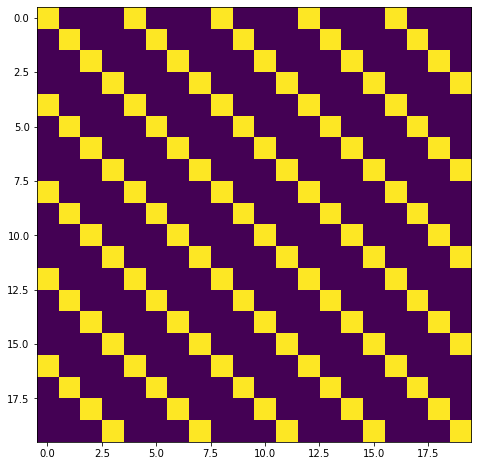

In [125]:
tmp = np.zeros(Heff_3rd.shape)
tmp[(Heff_symbolic[1]['']+Heff_symbolic[3]['']) != 0] = 1

fig, ax = plt.subplots(figsize = (12,8))
ax.imshow(tmp)

In [126]:
import pickle
with open('Heff_Bz_20G_9th_full.dat', 'rb') as rfp:
    Hpertubation = pickle.load(rfp)

In [234]:
Hpertubation[1].keys()

dict_keys(['xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz'])

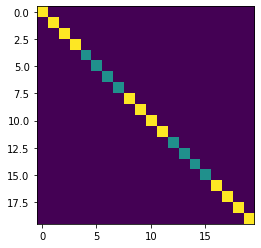

In [238]:
plt.imshow(np.abs(Hpertubation[1]['zz']))

In [218]:
Heff_full_3rd = np.zeros([20,20], dtype = np.complex)
for Hp in Hpertubation[1].values():
    Heff_full_3rd += Hp
# for Hp in Hpertubation[3].values():
#     Heff_full_3rd += Hp

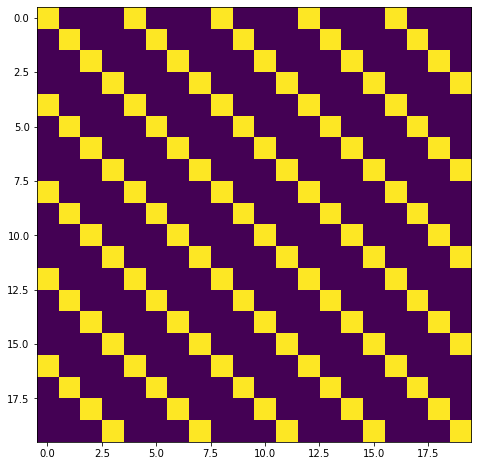

In [219]:
tmp_num = np.zeros(Heff_full_3rd.shape)
tmp_num[(Heff_full_3rd != 0)] = 1

fig, ax = plt.subplots(figsize = (12,8))
ax.imshow(tmp_num)

In [166]:
tmp = Heff_3rd[0,0]

In [184]:
dict_symbols_zero = {val: 0 for val in Hpert_symbols['HSx'].values()}
dict_symbols_zero.update({val: 0 for val in Hpert_symbols['HSy'].values()})

In [204]:
import itertools
from tqdm import tqdm_notebook as tqdm

Heff_3rd_HSz = np.zeros(Heff_3rd.shape, dtype = object)
for i,j in tqdm(itertools.product(range(Heff_3rd.shape[0]), range(Heff_3rd.shape[1])), total = np.product(Heff_3rd.shape)):
    Heff_3rd_HSz[i,j] = Heff_3rd[i,j].subs(dict_symbols_zero)

In [215]:
Heff_3rd_HSz[0,0]

-2.49131030963993e-11*<2;-2;-0.5;-0.5|HSz|3;-2;-0.5;-0.5>*<3;-2;-0.5;-0.5|HSz|2;-2;-0.5;-0.5> + 1.0*<2;-2;-0.5;-0.5|HSz|3;-2;-0.5;-0.5>*(1.54626339799731e-32*<2;-2;-0.5;-0.5|HSz|3;-2;-0.5;-0.5>*<3;-2;-0.5;-0.5|HSz|2;-2;-0.5;-0.5>**2 - 6.62684313427426e-33*<3;-2;-0.5;-0.5|HSz|2;-2;-0.5;-0.5>*<3;-2;-0.5;-0.5|HSz|4;-2;-0.5;-0.5>*<4;-2;-0.5;-0.5|HSz|3;-2;-0.5;-0.5>)

In [214]:
Heff_symbolic[1][''][10,18]

(3.7369654644551e-11*<1;1;0.5;-0.5|HSx|2;2;0.5;-0.5> + 3.7369654644551e-11*<1;1;0.5;-0.5|HSy|2;2;0.5;-0.5>)*(1.0*<2;0;0.5;-0.5|HSx|1;1;0.5;-0.5> + 1.0*<2;0;0.5;-0.5|HSy|1;1;0.5;-0.5>) + (1.0*<2;0;0.5;-0.5|HSx|3;1;0.5;-0.5> + 1.0*<2;0;0.5;-0.5|HSy|3;1;0.5;-0.5>)*(-2.49131030963993e-11*<3;1;0.5;-0.5|HSx|2;2;0.5;-0.5> - 2.49131030963993e-11*<3;1;0.5;-0.5|HSy|2;2;0.5;-0.5>)